<div style="color:red">!!! N.B. : Toutes les informations ci-dessous sont extraites à partir du fichier fourni dans le livrable et datant du 09/03/2017. <br> 
Aujourd'hui, le fichier a plus que doublé de volume, on est passé d'un peu moins de 140 000 enregistrements à plus de 326 000 grâce à l'apport d'enregistrements principalement américains. </div>

<h2>1- Analyse multivariée</h2>

Reprise du code permettant d'aboutir au dataframe des variables continues ayant une valeur de skewness

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA    
import sklearn.preprocessing as prep
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from matplotlib.gridspec import GridSpec
import time
import csv
import re
import warnings
warnings.filterwarnings('ignore')

from subprocess import check_output
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from gensim import models
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from string import punctuation
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

# fichier des données, adresse à adapter
dfOriginel = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')
# fichier des données de la recette (n° des articles et quantités respectives)
csvReader = csv.reader(open("recette.csv", "rb"))

def getDfContinuesSkewed(_df):
    """Sépare les variables continues et non continues puis crée un dataframe des variables continues ordonnées suivant leur skew croissant
    Arguments:
    _df -- dataframe contenant les données initiales
    Retour: 
    dfContinuesSkewed -- dataframe contenant les variables continues ordonnées suivant leur skew croissant
    dfContinues -- dataframe contenant les variables continues
    dfNonContinues -- dataframe contenant les variables non continues
    """
    
    # séparation variables continues / non continues                                      
    dfContinues = pd.DataFrame()
    dfNonContinues = pd.DataFrame()
    dfSans100NaN = pd.DataFrame()
    co = _df.count()
    i = 0
    while i < _df.shape[1]:
        if co[i] > 0:
            dfSans100NaN.insert(dfSans100NaN.shape[1], _df.columns[i], _df[_df.columns[i]])
        i = i + 1
        
    i = 0
    while i < dfSans100NaN.shape[1]:
        if dfSans100NaN.dtypes[i] == np.float64 or dfSans100NaN.dtypes[i] == np.int32:
            dfContinues.insert(dfContinues.shape[1], dfSans100NaN.columns[i], dfSans100NaN[dfSans100NaN.columns[i]])
        else:
            dfNonContinues.insert(dfNonContinues.shape[1], dfSans100NaN.columns[i], dfSans100NaN[dfSans100NaN.columns[i]])
        i = i + 1

    dfNanContinues = 100*(1-dfContinues.count()/dfContinues.shape[0])
  
    # normalisation
    dfContinues = (dfContinues-dfContinues.mean()) / dfContinues.std()
    
    
    # tableau des valeurs d'asymétrie afin de ne garder que les variables avec un skew (élimine les variables vides ou quasiment vides
    tabSkewness = []
    i = 0
    while i < dfContinues.shape[1]:    
        if ~np.isnan(dfContinues[dfContinues.columns[i]].skew()):
            tabSkewness.append((dfContinues.columns[i], dfContinues[dfContinues.columns[i]].skew(), dfNanContinues[dfContinues.columns[i]], co[i]))
        i = i + 1
        
    # tableau ordonné des valeurs d'asymétrie
    tabSkewnessSorted = sorted(tabSkewness, key=lambda x:x[1])
    
    # dataframe des variables continues ayant une valeur de skewness
    dfContinuesSkewed = pd.DataFrame()
    i = 0
    while i < len(tabSkewnessSorted):
        dfContinuesSkewed.insert(dfContinuesSkewed.shape[1], tabSkewnessSorted[i][0], _df[tabSkewnessSorted[i][0]])
        i = i + 1
        
    return dfContinuesSkewed, dfContinues, dfNonContinues

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gewurz14\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gewurz14\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Avant de voir la heatmap de la matrice de corrélation des variables, on peut regarder quelques exemples de comportement de quelques variables vis-à-vis des autres :

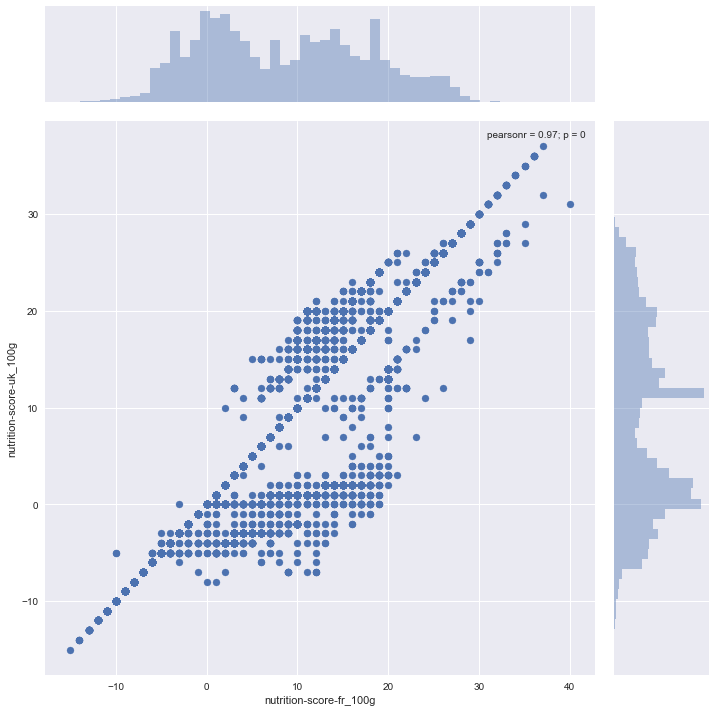

In [2]:
sns.jointplot(x="nutrition-score-fr_100g", y="nutrition-score-uk_100g", data=dfOriginel, size=10)

<u>Commentaires</u> :<br>
On peut voir grâce à ce graphique que nutrition-score-fr_100g et nutrition-score-uk_100g sont très corrélés, et que souvent ils sont même égaux ("droite" y=x)

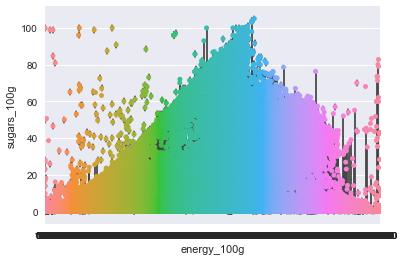

In [3]:
ax=sns.boxplot(x="energy_100g",y="sugars_100g",data=dfOriginel)
ax=sns.stripplot(x="energy_100g",y="sugars_100g",data=dfOriginel,jitter=True)

On voit sans surprise que globalement l'augmentation du taux de sucre s'accompagne de celle de l'énergie. Toutefois, on remarque également, là aussi sans surprise, que d'autres facteurs doivent entrer en jeu dans l'énergie totale de l'article puisque pour un même taux de sucre, on a une grande variabilité de l'energie.  

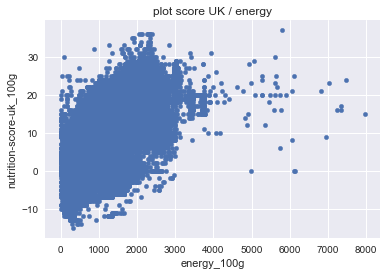

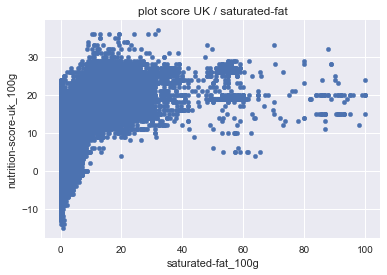

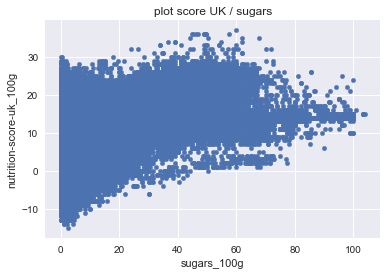

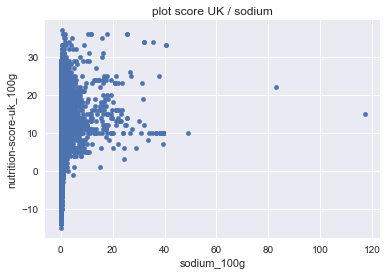

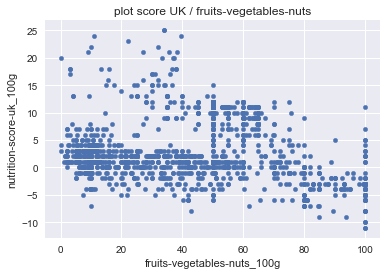

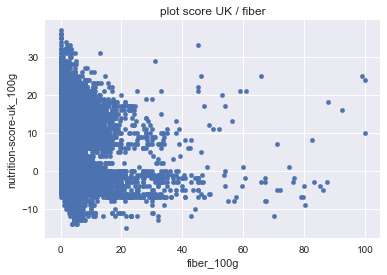

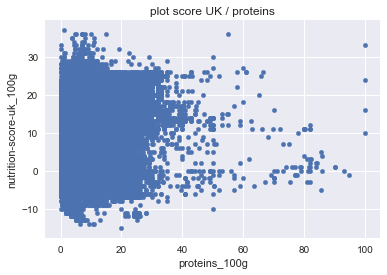

In [4]:
dfOriginelEnergyLow = dfOriginel[dfOriginel['energy_100g']<10000]
dfOriginelEnergyLow.plot(kind="scatter",x="energy_100g", y="nutrition-score-uk_100g",title="plot score UK / energy", legend=True)
dfOriginel.plot(kind="scatter",x="saturated-fat_100g", y="nutrition-score-uk_100g",title="plot score UK / saturated-fat", legend=True)
dfOriginel.plot(kind="scatter",x="sugars_100g", y="nutrition-score-uk_100g",title="plot score UK / sugars", legend=True)
dfOriginel.plot(kind="scatter",x="sodium_100g", y="nutrition-score-uk_100g",title="plot score UK / sodium", legend=True)
dfOriginel.plot(kind="scatter",x="fruits-vegetables-nuts_100g", y="nutrition-score-uk_100g",title="plot score UK / fruits-vegetables-nuts", legend=True)
dfOriginel.plot(kind="scatter",x="fiber_100g", y="nutrition-score-uk_100g",title="plot score UK / fiber", legend=True)
dfOriginel.plot(kind="scatter",x="proteins_100g", y="nutrition-score-uk_100g",title="plot score UK / proteins", legend=True)

Parmi les 7 variables utilisées pour construire le score nutritionnel britannique :
- on observe bien le mouvement "vers le haut à droite" de la corrélation positive pour les 3 variables energy_100g, saturated-fat_100g et sugars_100g, 
- le score élevé et supérieur à 0 dès qu'il y a du sel,
- le mouvement "descendant" des points de la variable des fruits-vegetables-nuts,
- les scores plutôt négatifs quand il y a des fibres, 
- pour ce qui est des protéines, il n'y a rien de bien marqué, d'autres facteurs devant être plus influents. 

<h5>Heatmap de la matrice de corrélation</h5>

Définition de la méthode de création de la heatmap

In [5]:
def heatmap(_df, _methode, _title):
    """Affichage de la heatmap de la matrice de corrélation des variables continues
    Arguments:
    _df -- dataframe contenant les variables
    _methode -- méthode statistique pour la corrélation, Pearson, Spearman ou Kendall
    _title -- titre de la heatmap
    """

    # suppression des figures
    plt.clf()
    # on calcule la matrice de corrélation pour le dataframe _df passé en paramètre
    corr = _df.corr(method=_methode)
    # masque d'affichage de la heatmap
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(12,12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # traçage de la heatmap
    sns.heatmap(corr, cmap=cmap, cbar_kws={"shrink": .5}, mask=mask)
    plt.title(_title)
    plt.show()
    

Traçage de la heatmap (corrélation des données gardant les données manquantes NaN) : 

On devrait dès le début annuler les variables de l'enregistrement repéré dans la phase de datacleaning, mais il est intéressant de voir par la suite que l'ACP peut également mettre en exergue des enregistrements "hors normes" comme nous allons le voir par la suite. On refera après les calculs sans le fameux enregistrement 15666666666.  

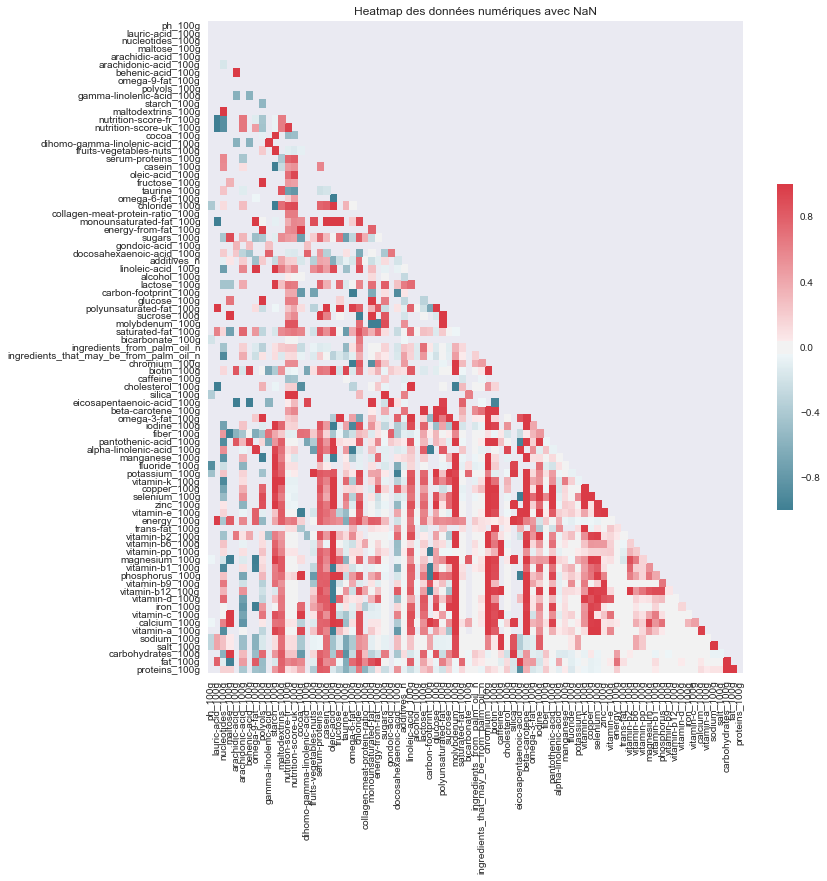

In [6]:
dfContinuesSkewed, dfContinues, dfNonContinues = getDfContinuesSkewed(dfOriginel)

heatmap(dfContinuesSkewed, "pearson", u"Heatmap des données numériques avec NaN")

Test d'une heatmap en remplaçant les NaN par 0 : 

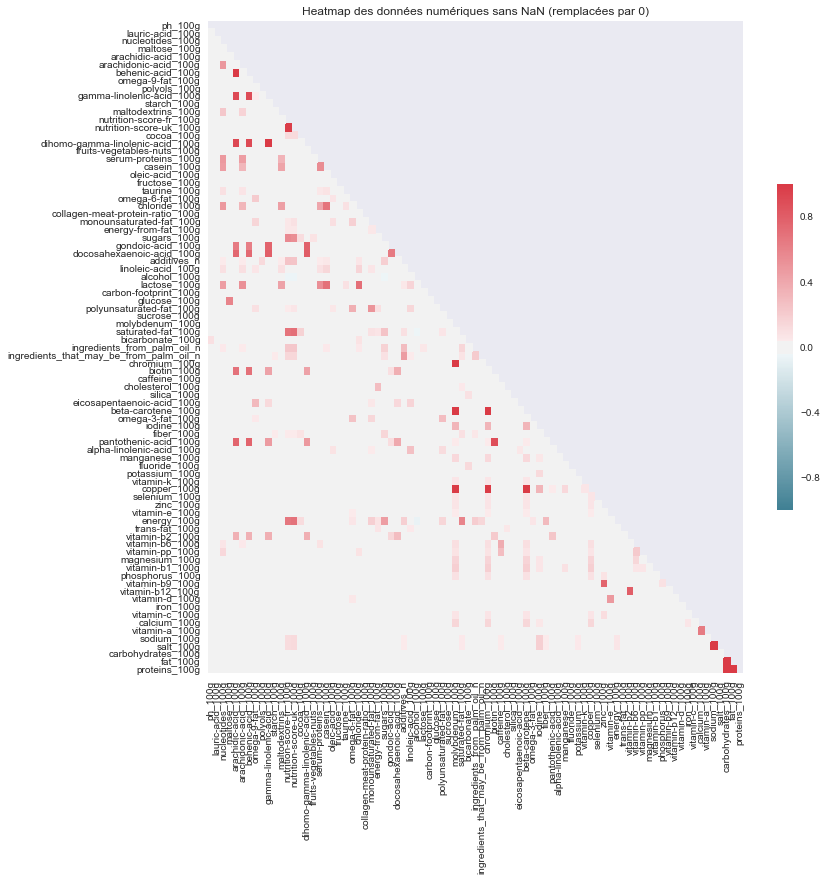

In [7]:
dfContinuesSkewedSansNaN = dfContinuesSkewed.fillna(0)
heatmap(dfContinuesSkewedSansNaN, "pearson", u"Heatmap des données numériques sans NaN (remplacées par 0)")

<u>Commentaires</u> : <br>
On observe clairement que remplacer les données manquantes par toujours la même valeur, 0 (ou même par la moyenne de chaque variable) modifie radicalement les corrélations. Pourtant, comme nous le verrons avec résultats de l'ACP, ce sont bien les variables qui ressortent de cette heatmap (celles avec de fortes corrélations) qui composent les composantes principales.

<h2>2- Suite du feature engineering</h2>

<u>Suppression d'une variable</u> : salt_100g

Quand on ajoute le paramètre annot=True à la Heatmap, on peut voir qu'il y a deux corrélations proches de 1, celle entre behenic-acid_100g et arachidic-acid_100g (0.999485), et celle entre salt_100g et sodium_100g (1.0).

                     behenic-acid_100g
arachidic-acid_100g           0.999485
             sodium_100g
sodium_100g          1.0


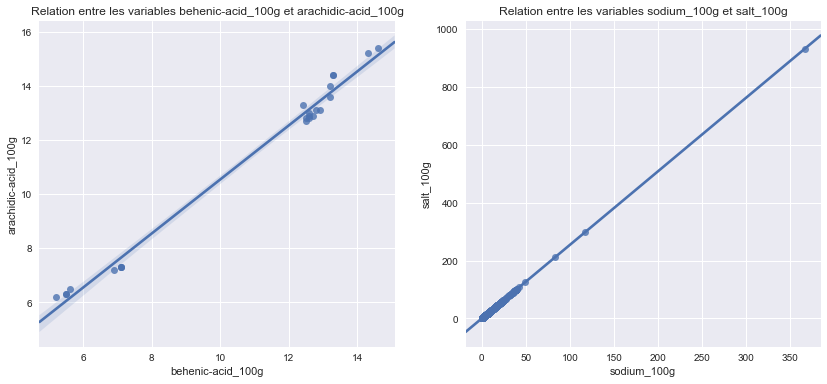

In [8]:
print(dfContinuesSkewedSansNaN.corr().iloc[4:5,6:7])
print(dfContinuesSkewedSansNaN.corr().iloc[78:79,78:79])

plt.clf()
plt.figure(figsize=(14,6))
plt.subplot(121)
ax = sns.regplot(x="behenic-acid_100g", y="arachidic-acid_100g", data=dfOriginel)
plt.title(u'Relation entre les variables behenic-acid_100g et arachidic-acid_100g')
plt.subplot(122)
ax = sns.regplot(x="sodium_100g", y="salt_100g", data=dfOriginel)
plt.title(u'Relation entre les variables sodium_100g et salt_100g')
plt.show()

<u>Commentaires</u> : <br>
On peut voir que même si les deux valeurs (0.999485 et 1.0) sont proches l'une de l'autre et de 1, ques ces deux ensembles de données semblent suivre un modèle linéaire, on ne peut pas les traiter de la même façon. En effet, si la corrélation entre les deux variables behenic-acid_100g et arachidic-acid_100g est proche de 1, elle n'est pas identique à 1, on peut le voir sur le graphe où pour des données assez proches sur l'axe du behenic-acid_100g, il y a quand même des différences notables sur ces valeurs de arachidic-acid_100g. La corrélation n'est donc pas suffisante pour prendre le risque de supprimer l'une des deux variables. Par contre, la corrélation entre salt_100g et sodium_100g est parfaite (on peut remarquer que leur ratio se situe près de 2.4), ce qui semble normal si on considère que le "sel" est simplement du chlorure de sodium. Les deux variables donnnent des informations redondantes et de la complexité inutile, on peut donc, dans un souci de diminution de la complexité de ce jeu de données, supprimer l'une des deux variables, par exemple salt_100g. En effet, sodium_100g est la variable utilisée dans le score d'un article, il est donc préférable de la garder dans le dataset. 

A partir de maintenant, on ne tiendra plus compte de la variable salt_100g dans le jeu de données.

In [9]:
dfOriginel.drop('salt_100g', axis=1, inplace=True)
dfContinuesSkewed.drop('salt_100g', axis=1, inplace=True)
dfContinuesSkewedSansNaN.drop('salt_100g', axis=1, inplace=True)

<u>Ajout d'une variable à prédire</u> : countries_tags <br>

Il peut être intéressant, pour un industriel, de connaître les habitudes alimentaires nationales afin de ne pas proposer à la vente des articles dont la composition est trop éloignée des us et coutumes (des goûts ou des éléments présents sur place etc.)
De même pour un chercheur, il peut être intéressant d'analyser les composants des aliments et comparer les résultats avec la présence éventuelle de certaines maladies dans certains pays. 
On va donc transformer la variable texte countries_tags en une variable continue (discrète binaire) qui prendra : 
- la valeur 1 quand countries_tags contient un tag du territoire français (france, guadeloupe, saint-pierre-and-miquelon etc.),
- la valeur 0 sinon

La nouvelle variable predict possède un skew de : -0.578973149465


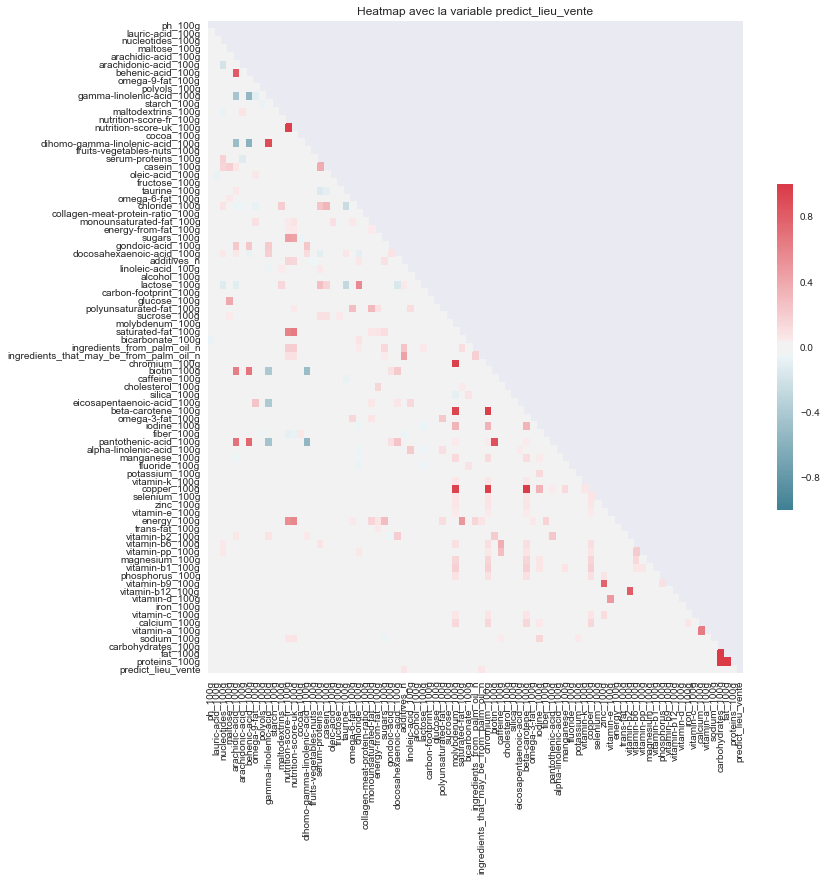

In [10]:
# transformation de la variable texte countries_tags en la variable continue (discrète binaire) predict_lieu_vente
dfContinues["predict_lieu_vente"] = np.where(dfOriginel["countries_tags"].str.contains("en:france|en:french|en:new-caledonia|en:guadeloupe|en:martinique|en:reunion|en:saint-pierre-and-miquelon")==True, 1, 0)

print("La nouvelle variable predict possède un skew de : {0}".format(dfContinues["predict_lieu_vente"].skew()))

# ajout de la variable predict_lieu_vente dans la liste des variables ayant une valeur de skew
dfContinuesSkewedPredict = dfContinuesSkewed.copy()
dfContinuesSkewedPredict.insert(dfContinuesSkewedPredict.shape[1], "predict_lieu_vente", dfContinues["predict_lieu_vente"])

# normalisation des données
dfContinuesSkewedPredict = (dfContinuesSkewedPredict-dfContinuesSkewedPredict.mean()) / dfContinuesSkewedPredict.std()

dfContinuesSkewedPredictSansNaN = dfContinuesSkewedPredict.fillna(0)

# heatmap pour visualiser les corrélations de la variable à prédire avec les autres variables
heatmap(dfContinuesSkewedPredictSansNaN, "pearson", u"Heatmap avec la variable predict_lieu_vente")


<u>Commentaires</u> : <br>
On n'observe pas de corrélations marquées entre la variable à prédire (Vendu en France ou non) et d'éventuels éléments particuliers.

<h2>3- Suite de l'analyse multivariée : Analyse en Composantes Principales</h2>

1ère composante de l'ACP

In [11]:
dfContinuesSkewedSansNaNNormalise = prep.StandardScaler().fit_transform(dfContinuesSkewedSansNaN)

def composantesPrincipale(_dfNormalise, _dfNonNormalise, _nombre_composantes, _numero_composante):
    """Affichage des dix premières variables importantes d'une composante principale de l'ACP
    Arguments:
    _dfNormalise -- dataframe contenant les variables normalisées pour l'ACP
    _dfNonNormalise -- dataframe contenant les variables non normalisées
    _nombre_composante -- nombre de composantes principales pour l'ACP
    _numero_composante -- numéro de la composante principale à afficher
    """
    pca = PCA(n_components=_nombre_composantes).fit(prep.scale(_dfNormalise)) 

    pca_df = pd.DataFrame(pca.components_[_numero_composante])
    pca_df.columns = ['coeff']

    feat_pca = pd.DataFrame(_dfNonNormalise.columns.values)
    feat_pca.columns = ['features']

    pca_feat_importances = pd.merge(feat_pca, pca_df, left_index=True, right_index=True)
    pca_feat_importances['importances']= pca_feat_importances['coeff']/pca_feat_importances['coeff'].sum()*100
    pca_feat_importances['importances'] = pca_feat_importances['importances'].apply(lambda x:abs(int(x)))
    print(pca_feat_importances.sort(['importances'], ascending=[0]).head(10))

composantesPrincipale(dfContinuesSkewedSansNaNNormalise, dfContinuesSkewedSansNaN, 2, 0)
    

                            features     coeff  importances
4                arachidic-acid_100g  0.402992           13
6                  behenic-acid_100g  0.402108           13
9          gamma-linolenic-acid_100g  0.384935           12
15  dihomo-gamma-linolenic-acid_100g  0.386362           12
29         docosahexaenoic-acid_100g  0.335400           11
53             pantothenic-acid_100g  0.287496            9
44                       biotin_100g  0.268319            9
28                 gondoic-acid_100g  0.283269            9
65                   vitamin-b2_100g  0.170798            5
55                    manganese_100g  0.001451            0


<u>Commentaires</u> : <br>
Comme on peut le voir sur la heatmap, on peut repérer les 5 principales variables de la première composante principale. 

2ème composante de l'ACP

In [12]:
composantesPrincipale(dfContinuesSkewedSansNaNNormalise, dfContinuesSkewedSansNaN, 2, 1)

              features     coeff  importances
59         copper_100g  0.466216           12
43       chromium_100g  0.466293           12
49  beta-carotene_100g  0.466004           12
38     molybdenum_100g  0.466408           12
51         iodine_100g  0.200090            5
69     vitamin-b1_100g  0.121512            3
66     vitamin-b6_100g  0.079838            2
68      magnesium_100g  0.100524            2
76        calcium_100g  0.096758            2
55      manganese_100g  0.087808            2


<u>Commentaires</u> : <br>
Pour cette deuxième composante de l'ACP, 4 variables se détachent en importance, nous verrons par la suite qu'elles sont dues à un seul enregistrement. 

<h5>Graphique de la participation des différentes composantes dans l'explication de la variance</h5>

In [13]:
def getPropre(_df, _graphe):
    """Méthode permettant d'obtenir les valeurs propres et les vecteurs propres de la matrice de corrélation, affiche également le graphe de la participation de chaque variable à l'explication de la variance
    Arguments:
    _df -- dataframe contenant les variables
    _graphe -- booléen indiquant si on veut que le graphe soit affiché ou non
    Retour: la liste des tuples (valeurs propres, vecteurs propres)
    """
    
    cor_mat1 = np.corrcoef(_df.T)
    eig_vals, eig_vecs = np.linalg.eig(cor_mat1)
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    if _graphe:
        with plt.style.context('seaborn-whitegrid'):
            plt.clf()
            plt.figure(figsize=(12, 8))
            plt.bar(range(_df.shape[1]), var_exp, alpha=0.5, align='center',
                    label=u'Variance expliquée individuellement')
            plt.step(range(_df.shape[1]), cum_var_exp, where='mid',
                     label=u'Variance expliquée par cumul')
            plt.ylabel('Pourcentage')
            plt.xlabel('Composantes principales')
            plt.title(u'Variance expliquée pour chaque composante principale et cumul')
            plt.legend(loc='best')
            plt.tight_layout()
            plt.show()    
    
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    
    return eig_pairs

In [14]:
print(dfContinuesSkewedSansNaNNormalise.shape)

(139578L, 82L)


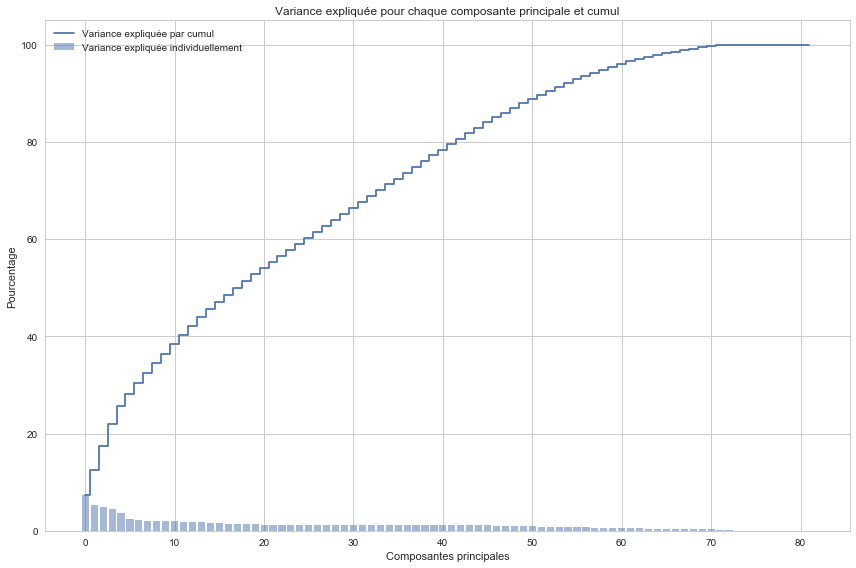

In [15]:
eig_pairs = getPropre(dfContinuesSkewedSansNaNNormalise, True)

<u>Commentaires</u> : <br>
Le schéma nous indique qu'aucune des composantes principales n'explique à elle seule une majorité de la variance. Elles sont au contraire assez proches les unes des autres.

In [16]:
for i in range(30):
    print(eig_pairs[i][0])

5.98279513615
4.35114977535
4.02929546332
3.7164756789
2.99995465236
2.05624109561
1.78982187821
1.72789431447
1.6298935193
1.59424583789
1.60024898469
1.51730845973
1.51307978562
1.47764510724
1.34442842113
1.30427069096
1.20636989095
1.18756691322
1.18658388922
0.214267971244
0.0727355813403
0.120473328154
0.341356280342
0.218130145742
0.313066103764
0.273068625811
0.248819203372
0.294365174339
0.263871512054
1.1153640965


In [17]:
def grapheACP2Composantes(_val_vect_propres, _df, _var_prediction):
    """Représentation graphique des deux composantes principales de l'ACP
    Arguments:
    _val_vect_propres -- tuples des valeurs propres et des vecteurs propres de la matrice de corrélation
    _df -- dataframe des variables continues dont les valeurs manquantes ont été mises à 0
    _var_prediction -- variable à prédire
    """

    # tri des tuples (eigenvalue, eigenvector) par ordre décroissant
    _val_vect_propres.sort(key=lambda x: x[0], reverse=True)
    
    matrix_w = np.hstack((_val_vect_propres[0][1].reshape(_df.shape[1],1), _val_vect_propres[1][1].reshape(_df.shape[1],1)))
    
    Y = _df.dot(matrix_w)

    plt.clf()
    plt.figure(figsize=(10, 6))
    for lab, col, m in zip(('FR', 'PASFR'), ('lime', (1,0,0,0.3)), ('o', '^')):
        plt.scatter(Y[_var_prediction==lab, 0], Y[_var_prediction==lab, 1], label=lab, c=col, marker=m)
    plt.xlabel('Composante principale 1')
    plt.ylabel('Composante principale 2')
    plt.title(u'ACP, représentation des deux premières composantes principales')
    plt.legend(loc='lower right')
    plt.show()  

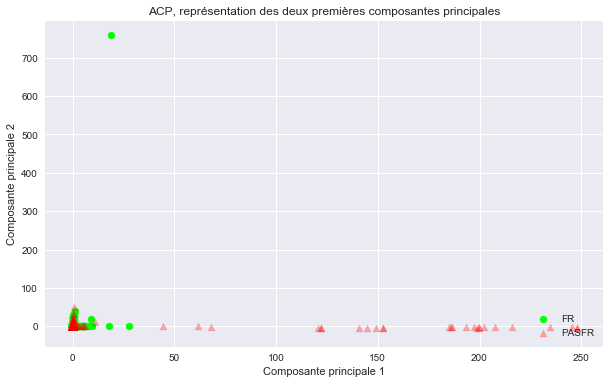

In [18]:
predict_lieu_vente = np.where(dfOriginel["countries_tags"].str.contains("en:france|en:french|en:new-caledonia|en:guadeloupe|en:martinique|en:reunion|en:saint-pierre-and-miquelon")==True, "FR", "PASFR")
grapheACP2Composantes(eig_pairs, dfContinuesSkewedSansNaNNormalise, predict_lieu_vente)

On observe qu'il y a un enregistrement qui possède une valeur très différente des autres pour la composante 2.
Pour la repérer, on peut passer par le code directement implémenté par scikit-learn:

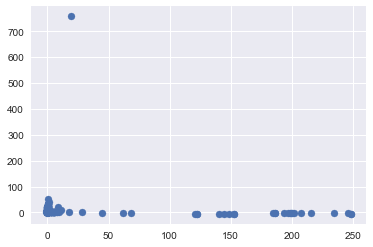

(60374, array([  18.9739203 ,  757.86721715]))


In [19]:
plt.clf()
sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(dfContinuesSkewedSansNaNNormalise)    
plt.scatter(Y_sklearn[:,0], Y_sklearn[:,1])
plt.show()
for i in range(Y_sklearn.shape[0]):
    if Y_sklearn[i][1] > 700:
        print(i, Y_sklearn[i])


Il s'agit du code '3401528535864'.
Pour beaucoup des ingrédients, il possède des valeurs très éloignées des moyennes. 

Comparaison des heatmap avec et sans l'enregistrement:

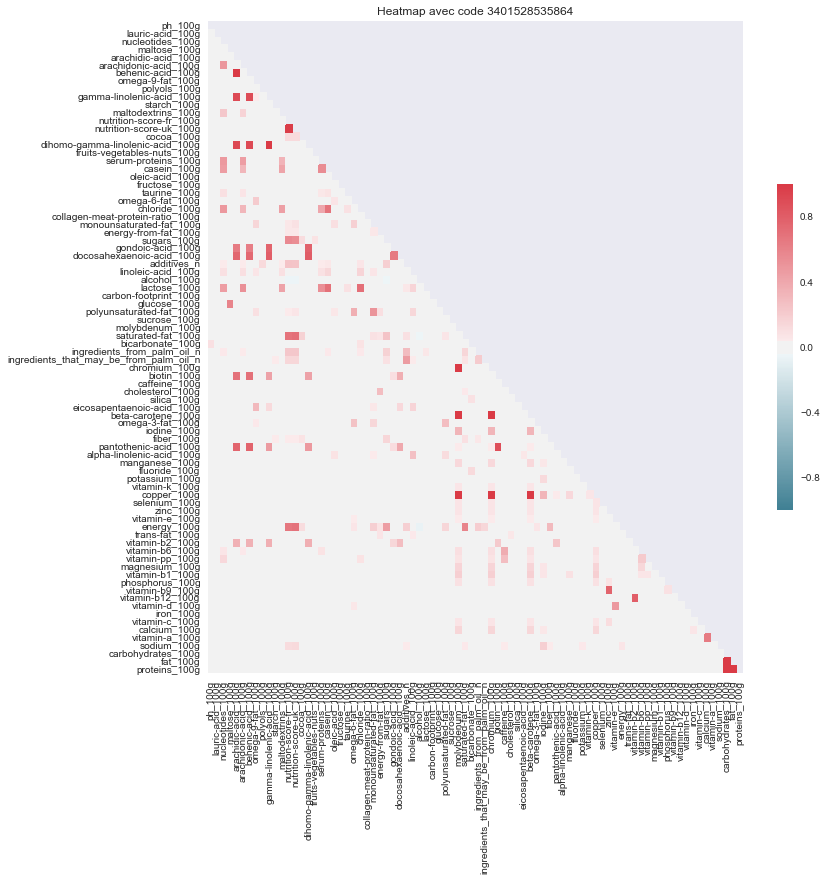

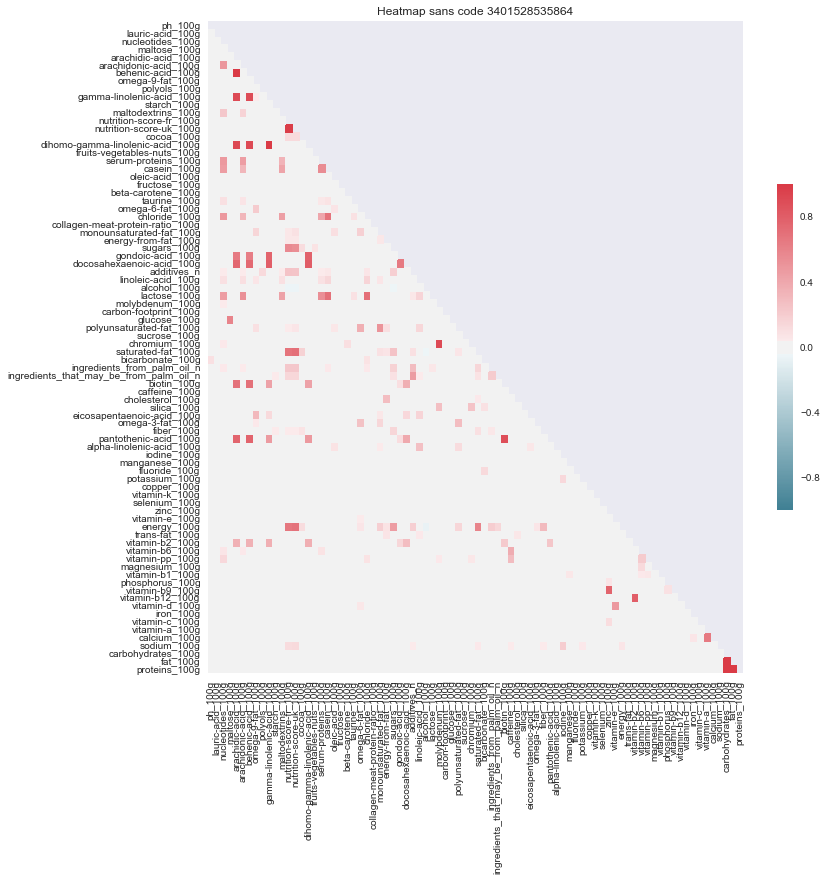

In [20]:
dfContinuesSkewed, dfContinues, dfNonContinues = getDfContinuesSkewed(dfOriginel)
dfContinuesSkewedSansNaN = dfContinuesSkewed.fillna(0)
heatmap(dfContinuesSkewedSansNaN, "pearson", u"Heatmap avec code 3401528535864")

dfOriginelSans3401528535864 = dfOriginel[dfOriginel.code <> 3401528535864]
dfContinuesSkewedSans3401528535864, dfContinuesSans3401528535864, dfNonContinuesSans3401528535864 = getDfContinuesSkewed(dfOriginelSans3401528535864)
dfContinuesSkewedSansNaNSans3401528535864 = dfContinuesSkewedSans3401528535864.fillna(0)
heatmap(dfContinuesSkewedSansNaNSans3401528535864, "pearson", u"Heatmap sans code 3401528535864")

<u>Commentaires</u> : <br>
On peut voir que les points rouges des fortes corrélations pour les 4 premières variables de la 2ème composante principale copper_100g, beta-carotene_100g, molybdenum_100g et chromium_100g ont disparu du fait de la non prise en compte de l'enregistrement.

In [21]:
dfContinuesSkewedSansNaNSans3401528535864Normalise = prep.StandardScaler().fit_transform(dfContinuesSkewedSansNaNSans3401528535864)
composantesPrincipale(dfContinuesSkewedSansNaNSans3401528535864Normalise, dfContinuesSkewedSansNaNSans3401528535864, 5, 0)
composantesPrincipale(dfContinuesSkewedSansNaNSans3401528535864Normalise, dfContinuesSkewedSansNaNSans3401528535864, 5, 1)
composantesPrincipale(dfContinuesSkewedSansNaNSans3401528535864Normalise, dfContinuesSkewedSansNaNSans3401528535864, 5, 2)
composantesPrincipale(dfContinuesSkewedSansNaNSans3401528535864Normalise, dfContinuesSkewedSansNaNSans3401528535864, 5, 3)
composantesPrincipale(dfContinuesSkewedSansNaNSans3401528535864Normalise, dfContinuesSkewedSansNaNSans3401528535864, 5, 4)

                            features     coeff  importances
4                arachidic-acid_100g  0.403074           13
6                  behenic-acid_100g  0.402190           13
9          gamma-linolenic-acid_100g  0.385003           13
15  dihomo-gamma-linolenic-acid_100g  0.386430           13
30         docosahexaenoic-acid_100g  0.335458           11
45                       biotin_100g  0.268386            9
29                 gondoic-acid_100g  0.283310            9
52             pantothenic-acid_100g  0.287468            9
65                   vitamin-b2_100g  0.170785            5
55                    manganese_100g  0.000006            0
                   features     coeff  importances
34             lactose_100g  0.323893            7
18              casein_100g  0.307021            6
24            chloride_100g  0.303372            6
13  nutrition-score-uk_100g  0.311696            6
12  nutrition-score-fr_100g  0.309305            6
63              energy_100g  0.275

<u>Commentaires</u> : <br>
Les nouvelles variables qui ont pris leur place dans la 2ème composante principale, lactose_100g, casein_100, chloride_100g, etc. ont de fortes corrélations mais dans une moindre mesure. Les variables beta-carotene_100g, molybdenum_100g et chromium_100g ont "rétrogradé" dans la cinquième composante principale.
On peut remarquer que sur les 9 premières variables de la 1ère composante principale, il n'y a quasiment pas de modification de leurs importances respectives, ce qui semble normal puisque l'écart se faisait pour la deuxième composante principale et non sur la première.

In [22]:
print("Moyenne du copper_100g avec l'enregistrement : {0}".format(dfOriginel['copper_100g'].mean()))
print("Moyenne du copper_100g sans l'enregistrement : {0}".format(dfOriginelSans3401528535864['copper_100g'].mean()))
print("Division de la moyenne par : {0}".format(dfOriginel['copper_100g'].mean()/dfOriginelSans3401528535864['copper_100g'].mean()))
print("Moyenne du beta-carotene_100g avec l'enregistrement : {0}".format(dfOriginel['beta-carotene_100g'].mean()))
print("Moyenne du beta-carotene_100g sans l'enregistrement : {0}".format(dfOriginelSans3401528535864['beta-carotene_100g'].mean()))
print("Division de la moyenne par : {0}".format(dfOriginel['beta-carotene_100g'].mean()/dfOriginelSans3401528535864['beta-carotene_100g'].mean()))
print("Moyenne du molybdenum_100g avec l'enregistrement : {0}".format(dfOriginel['molybdenum_100g'].mean()))
print("Moyenne du molybdenum_100g sans l'enregistrement : {0}".format(dfOriginelSans3401528535864['molybdenum_100g'].mean()))
print("Division de la moyenne par : {0}".format(dfOriginel['molybdenum_100g'].mean()/dfOriginelSans3401528535864['molybdenum_100g'].mean()))
print("Moyenne du chromium_100g avec l'enregistrement : {0}".format(dfOriginel['chromium_100g'].mean()))
print("Moyenne du chromium_100g sans l'enregistrement : {0}".format(dfOriginelSans3401528535864['chromium_100g'].mean()))
print("Division de la moyenne par : {0}".format(dfOriginel['chromium_100g'].mean()/dfOriginelSans3401528535864['chromium_100g'].mean()))

Moyenne du copper_100g avec l'enregistrement : 0.234250759755
Moyenne du copper_100g sans l'enregistrement : 0.00359798666667
Division de la moyenne par : 65.106066658
Moyenne du beta-carotene_100g avec l'enregistrement : 0.518715117647
Moyenne du beta-carotene_100g sans l'enregistrement : 0.0798883030303
Division de la moyenne par : 6.49300458229
Moyenne du molybdenum_100g avec l'enregistrement : 0.000400690909091
Moyenne du molybdenum_100g sans l'enregistrement : 6.476e-05
Division de la moyenne par : 6.18732101746
Moyenne du chromium_100g avec l'enregistrement : 0.000191843
Moyenne du chromium_100g sans l'enregistrement : 4.35189473684e-05
Division de la moyenne par : 4.40826379315


<u>Commentaires</u> : <br>
Ne pas tenir compte de l'enregistrement divise la moyenne générale du copper_100g par plus de 65 et au moins par 4 pour les trois autres variables. On voit donc que cet enregistrement décelé par l'ACP présente des taux exceptionnels pour ces variables. Toutefois, si les valeurs des 3 variables de l'enregistrement de code 15666666666 étaient clairement aberrantes, rien ne semble ici justifier que ces valeurs soient annulées. 

Toutefois, pour mieux voir la disposition des valeurs de la variable predict_lieu_vente, on laisse pour l'instant de côté l'enregistrement qui étire la composante 2.

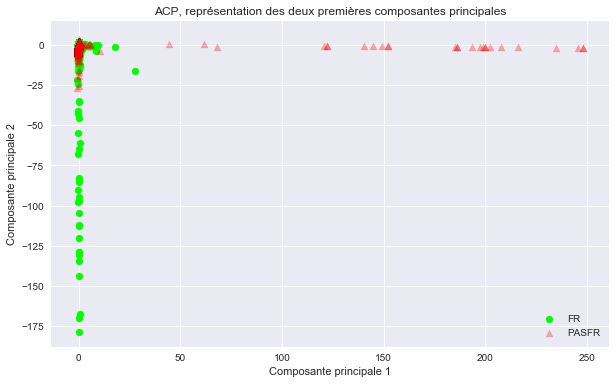

In [23]:
predictSans3401528535864 = np.where(dfOriginelSans3401528535864["countries_tags"].str.contains("en:france|en:french|en:new-caledonia|en:guadeloupe|en:martinique|en:reunion|en:saint-pierre-and-miquelon")==True, "FR", "PASFR")
eig_pairsSans3401528535864 = getPropre(dfContinuesSkewedSansNaNSans3401528535864Normalise, False)
grapheACP2Composantes(eig_pairsSans3401528535864, dfContinuesSkewedSansNaNSans3401528535864Normalise, predictSans3401528535864)

<u>Commentaires</u> : 
On voit bien les conséquences de la suppression de cet enregistrement, la valeur extrême de la composante 2 a disparu. 
L'interprétation sera décrite plus loin.

In [24]:
for i in range(40):
    print(eig_pairsSans3401528535864[i][0])

5.98311556143
4.03837940848
3.71708875516
2.99995465753
2.06577993035
2.05608880883
1.79948370359
1.72795602188
1.65112383438
1.61514736836
1.60019667796
1.51819518536
1.51456342528
1.47894413784
1.34452059951
1.30488415743
1.26840438686
1.18692983893
1.17902907397
1.11796078316
1.06359651022
1.040664521
1.02840997592
1.02014045074
1.01548035592
1.01319580304
1.00732135548
1.00534487254
1.00363654987
1.00345743893
1.00137838729
1.00026143899
0.999751443481
0.998934365674
0.998439108371
0.997194492284
0.994333069501
0.985439203586
0.981499572857
0.97731606336


<h2>4- Clustering</h2>

In [25]:
def graphe_KMeans(_df, _nb_clusters): #dfContinuesSkewedSansNaN
    """Représentation graphique des clusters d'après la méthode des k-means
    Arguments:
    _df -- dataframe des variables continues
    _nb_clusters -- nombre de clusters
    """
    deb = time.clock()
    
    reduced_data = PCA(n_components=2).fit_transform(_df)
    kmeans = KMeans(init='k-means++', n_clusters=_nb_clusters, n_init=10)
    kmeans.fit(reduced_data)
    fin1 = time.clock()
    h = 0.1     # point in the mesh [x_min, x_max]x[y_min, y_max].

    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    centroids = kmeans.cluster_centers_
    print("centroids = ",centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
    plt.title('K-means clustering on Marmite dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    fin2 = time.clock()
    print("Temps d'exécution du KMeans : {0}".format(fin1-deb))
    print("Temps d'exécution graphe : {0}".format(fin2-fin1))
    print("Inertie du K-means : {0}".format(kmeans.inertia_))

On annule les valeurs aberrantes de l'enregistrement de code 15666666666 et on refait tous les calculs sur cette nouvelle base

                            features     coeff  importances
4                arachidic-acid_100g  0.402716           14
6                  behenic-acid_100g  0.401832           13
9          gamma-linolenic-acid_100g  0.384659           13
15  dihomo-gamma-linolenic-acid_100g  0.386103           13
31         docosahexaenoic-acid_100g  0.335150           11
56             pantothenic-acid_100g  0.287276           10
47                       biotin_100g  0.268134            9
29                 gondoic-acid_100g  0.283080            9
68                   vitamin-b2_100g  0.170681            5
0                            ph_100g  0.000134            0
                       features     coeff  importances
12      nutrition-score-fr_100g  0.392212            8
66                  energy_100g  0.387386            8
13      nutrition-score-uk_100g  0.398520            8
30                     fat_100g  0.329881            7
42           saturated-fat_100g  0.330138            7
19        

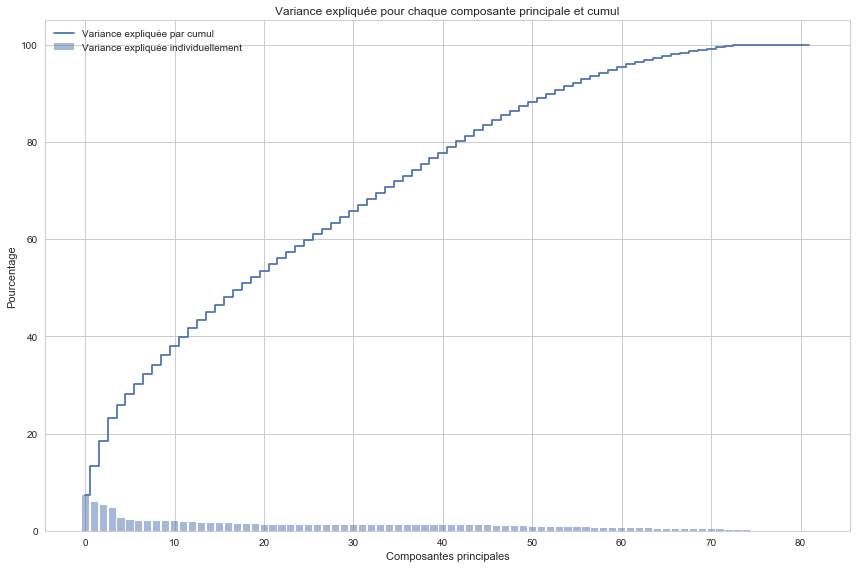

In [26]:
dfOriginelSansAberr = dfOriginel.copy() 
dfOriginelSansAberr = dfOriginelSansAberr.set_index('code', drop=False)
dfOriginelSansAberr['proteins_100g'][15666666666] = 0
dfOriginelSansAberr['fat_100g'][15666666666] = 0
dfOriginelSansAberr['carbohydrates_100g'][15666666666] = 0

dfContinuesSkewedSansAberr, dfContinuesSansAberr, dfNonContinuesSansAberr = getDfContinuesSkewed(dfOriginelSansAberr)
dfContinuesSkewedSansNaNSansAberr = dfContinuesSkewedSansAberr.fillna(0)
dfContinuesSkewedSansNaNSansAberrNormalise = prep.StandardScaler().fit_transform(dfContinuesSkewedSansNaNSansAberr)
composantesPrincipale(dfContinuesSkewedSansNaNSansAberrNormalise, dfContinuesSkewedSansNaNSansAberr, 2, 0)
composantesPrincipale(dfContinuesSkewedSansNaNSansAberrNormalise, dfContinuesSkewedSansNaNSansAberr, 2, 1)
eig_pairsSansAberr = getPropre(dfContinuesSkewedSansNaNSansAberrNormalise, True)

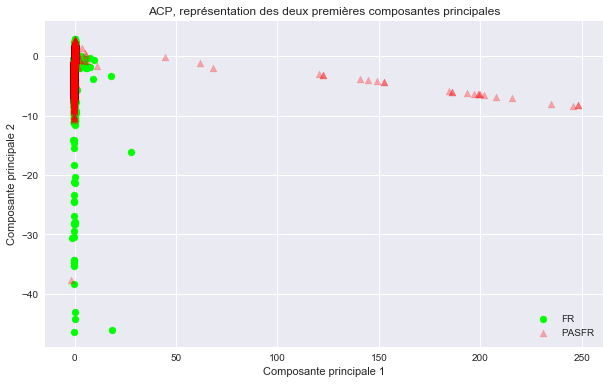

In [27]:
predict_lieu_venteSansAberr = np.where(dfOriginelSansAberr["countries_tags"].str.contains("en:france|en:french|en:new-caledonia|en:guadeloupe|en:martinique|en:reunion|en:saint-pierre-and-miquelon")==True, "FR", "PASFR")
grapheACP2Composantes(eig_pairsSansAberr, dfContinuesSkewedSansNaNSansAberrNormalise, predict_lieu_venteSansAberr)

<u>Commentaires</u> : <br>
L'annulation des valeurs pour l'enregistrement de code 15666666666 modifie légèrement la composante 1. Et on peut remarquer que la valeur extrême de la composante 2 a disparu.  
On peut repérer 3 zones, la composante principale 1 sur laquelle se positionnent principalement des articles non vendus en France, la composante principale 2 où on retrouve en grande partie des articles vendus en France, et une zone mixte où on retrouve les deux possibilités. 
On peut donc penser que les principaux éléments de la composante 1, arachidic-acid_100g, behenic-acid_100g, gamma-linolenic-acid_100g, dihomo-gamma-linolenic-acid_100g, se retrouvent principalement dans des articles non vendus en France, et qu'en ce qui concerne les éléments de la composante 2, nutrition-score-uk_100g, nutrition-score-fr_100g, energy_100g, saturated-fat_100g, fat_100g, carbohydrates_100g et sugars_100g, on les retrouve souvent dans les produits français, donc des produits assez riches. On retrouve également ces éléments gras dans un certain nombre d'articles non vendus en France. 

Il pourrait alors être intéressant de créer d'autres variables pour cibler les pays où certains éléments sont les plus représentés afin de comparer les modes régionaux apparents de consommation. 

<h5>Méthode des K-means</h5>

('centroids = ', array([[  1.65705981e-02,  -1.12186802e+00],
       [  1.84795464e+02,   5.77840811e+00],
       [ -1.67907420e-01,   3.27530383e+00]]))


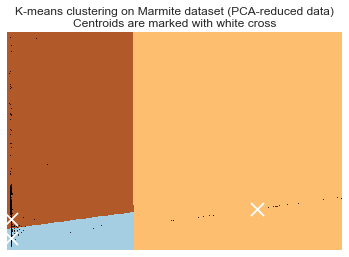

Temps d'exécution du KMeans : 1.1775453412
Temps d'exécution graphe : 0.421467716371
Inertie du K-means : 215488.471695


In [28]:
graphe_KMeans(dfContinuesSkewedSansNaNSansAberrNormalise, 3)

In [29]:
def graphe_MiniBatchKMeans(_df, _nb_clusters): #dfContinuesSkewedSansNaN
    """Représentation graphique des clusters d'après la méthode des MiniBatchKMeans
    Arguments:
    _df -- dataframe des variables continues
    _nb_clusters -- nombre de clusters
    """
    
    deb = time.clock()
    reduced_data = PCA(n_components=2).fit_transform(_df)
    miniBatchKmeans = MiniBatchKMeans(n_clusters=_nb_clusters, n_init=10)
    miniBatchKmeans.fit(reduced_data)
    fin1 = time.clock()
    h = 0.1     # point in the mesh [x_min, x_max]x[y_min, y_max].

    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = miniBatchKmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    centroids = miniBatchKmeans.cluster_centers_
    print("centroids = ",centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
    plt.title('MiniBatchKMeans clustering on Marmite dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    fin2 = time.clock()
    print("Temps d'exécution du MiniBatchKMeans : {0}".format(fin1-deb))
    print("Temps d'exécution graphe : {0}".format(fin2-fin1))
    print("Inertie du miniBatchKmeans : {0}".format(miniBatchKmeans.inertia_))

<h5>Méthode du MiniBatchKMeans</h5>

('centroids = ', array([[-0.12111581,  4.20768565],
       [ 0.02851935, -1.44097161],
       [-0.07523473,  0.90086184]]))


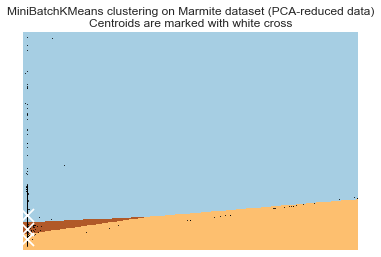

Temps d'exécution du MiniBatchKMeans : 0.740842871433
Temps d'exécution graphe : 1.39997084447
Inertie du miniBatchKmeans : 927753.719548


In [30]:
graphe_MiniBatchKMeans(dfContinuesSkewedSansNaNSansAberrNormalise, 3)

La méthode MiniBatchKMeans est un peu plus rapide que le KMeans.
Si deux des centres sont assez proches dans les deux méthodes, il y a toutefois une grosse différence sur le troisième, ce qui peut résulter de la différence de centre initial.

On peut aussi remarquer que l'inertie est bien plus faible sur le k-means que sur le MiniBatchKMeans. 

In [31]:
composantesPrincipale(dfContinuesSkewedSansNaNSansAberrNormalise, dfContinuesSkewedSansNaNSansAberr, 5, 0)
composantesPrincipale(dfContinuesSkewedSansNaNSansAberrNormalise, dfContinuesSkewedSansNaNSansAberr, 5, 1)
composantesPrincipale(dfContinuesSkewedSansNaNSansAberrNormalise, dfContinuesSkewedSansNaNSansAberr, 5, 2)
composantesPrincipale(dfContinuesSkewedSansNaNSansAberrNormalise, dfContinuesSkewedSansNaNSansAberr, 5, 3)
composantesPrincipale(dfContinuesSkewedSansNaNSansAberrNormalise, dfContinuesSkewedSansNaNSansAberr, 5, 4)

                            features     coeff  importances
4                arachidic-acid_100g  0.402715           14
6                  behenic-acid_100g  0.401831           13
9          gamma-linolenic-acid_100g  0.384661           13
15  dihomo-gamma-linolenic-acid_100g  0.386105           13
31         docosahexaenoic-acid_100g  0.335152           11
56             pantothenic-acid_100g  0.287270           10
47                       biotin_100g  0.268127            9
29                 gondoic-acid_100g  0.283085            9
68                   vitamin-b2_100g  0.170684            5
0                            ph_100g  0.000133            0
                       features     coeff  importances
12      nutrition-score-fr_100g  0.392213            8
66                  energy_100g  0.387385            8
13      nutrition-score-uk_100g  0.398521            8
30                     fat_100g  0.329877            7
42           saturated-fat_100g  0.330135            7
19        

<u>Commentaires</u> : <br>
On remarque que l'annulation des valeurs aberrantes du code 15666666666 ont fait "reculer" les variables concernées par le 3401528535864 de la 2ème à la 3ème composante (molybdenum, chromium etc.).

<h2>5- Recettes saines</h2>

Selon la Food Standards Agency, la variable nutrition-score-uk_100g est un système simple de score où des points sont alloués sur la base des contenus nutritifs de 100g de nourriture ou de boisson. Les points sont accordés pour des nutriments de classe 'A' que sont l'énergie, les graisses saturées, le sucre et le sel, et les nutriments de classe 'C' comme les fruits, légumes, noix, fibres, protéines. Les points des nutriments de la classe 'C' sont soustraits à ceux de la classe 'A'. Par exemple, les nourritures marquant plus de 4 points, ou les boissons marquant plus de 1 point, sont classifiées comme "moins saines" (less healthy), et sont par exemple sujettes à des contrôles de l'Ofcom sur la publicité faite aux enfants sur ces nourritures. 

On peut donc se baser sur cette variable pour avoir un critère pour déterminer si un article est globalement sain ou non. 

On peut d'ailleurs le vérifier sur la heatmap avec les fortes corrélations entre nutrition-score-uk_100g (et nutrition-score-fr_100g puisque le score français est dérivé du score anglais et adapté au marché français selon la description des variables sur le site de l'openfoodfacts) et les variables comme sugars_100g, saturated-fat_100g et energy_100g et en moindres mesures à fiber_100g, energy-from-fat_100g, salt_100g etc. 
De la même façon, l'ACP regroupe dans la deuxième composante principale les variables nutrition-score-fr_100g, energy_100g, nutrition-score-uk_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g et proteins_100g, des variables participant à l'édification du score nutritif. 

De la même façon que pour la variable de lieu de vente, on peut créer une variable binaire S (sain) / NS (non sain) en se basant sur le score. NS pour une nourriture de score anglais supérieur ou égal à 4 pour une nourriture solide, et supérieur ou égal à 1 pour une nourriture liquide, S sinon. On peut utiliser pour cela la variable quantity en repérant si l'unité de mesure correspond à un poids ou à une contenance (approximativement, car il y a des exceptions à traiter plus spécifiquement)

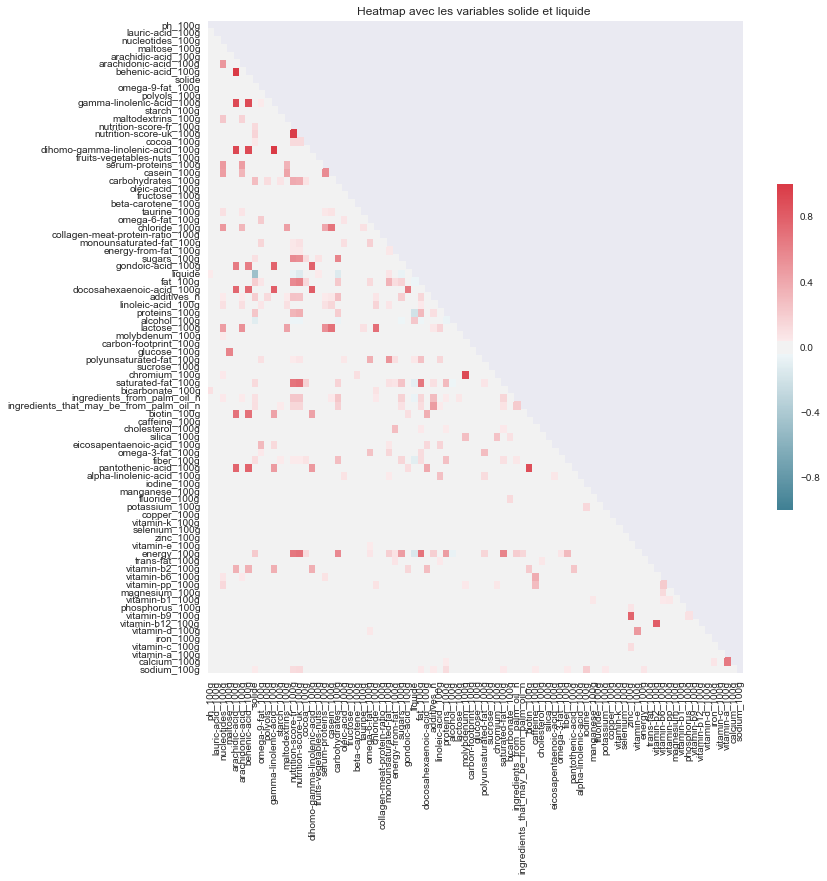

In [32]:
dfOriginelSansAberr = dfOriginel.copy() #15666666666
solide = np.where(dfOriginel["quantity"].str.contains("l|L")==False, 1, 0)
liquide = np.where(dfOriginel["quantity"].str.contains("l|L")==True, 1, 0)
dsl = {'solide' : solide, 'liquide' : liquide}
dfsl = pd.DataFrame(dsl)
dfOriginelS = pd.concat([dfOriginelSansAberr, dfsl], axis = 1)

dfOriginelS = dfOriginelS.set_index('code', drop=False)
dfOriginelS['proteins_100g'][15666666666] = 0
dfOriginelS['fat_100g'][15666666666] = 0
dfOriginelS['carbohydrates_100g'][15666666666] = 0
dfOriginelS = dfOriginelS[dfOriginelS.code <> 3401528535864]

dfContinuesSkewed, dfContinues, dfNonContinues = getDfContinuesSkewed(dfOriginelS)

dfContinuesSkewedSansNaN = dfContinuesSkewed.fillna(0)

heatmap(dfContinuesSkewedSansNaN, "pearson", u"Heatmap avec les variables solide et liquide ")

In [33]:
print(dfContinuesSkewedSansNaN.corr().iloc[7:33,7])
print("Corrélation entre les variables liquide et solide : {0}".format(dfContinuesSkewedSansNaN.corr().iloc[7,32]))

solide                              1.000000
omega-9-fat_100g                   -0.008942
polyols_100g                        0.028959
gamma-linolenic-acid_100g          -0.015075
starch_100g                         0.027707
maltodextrins_100g                  0.005809
nutrition-score-fr_100g             0.125398
nutrition-score-uk_100g             0.158163
cocoa_100g                          0.061270
dihomo-gamma-linolenic-acid_100g   -0.014801
fruits-vegetables-nuts_100g         0.018162
serum-proteins_100g                 0.006211
casein_100g                         0.008577
carbohydrates_100g                  0.285801
oleic-acid_100g                    -0.004864
fructose_100g                       0.001977
beta-carotene_100g                  0.001347
taurine_100g                       -0.006369
omega-6-fat_100g                   -0.011115
chloride_100g                       0.007488
collagen-meat-protein-ratio_100g    0.028009
monounsaturated-fat_100g           -0.024041
energy-fro

<u>Commentaires</u> : <br>
Quand la variable quantity contient les caractères "l" ou "L" (pour ml, cl, litre, fl oz, etc.), on affecte la valeur 1 à la variable liquide, 0 à la variable solide. Si elle ne les contient pas, on affecte 1 à la variable solide, et 0 à la variable liquide. Quand la variable n'est pas renseignée, on met 0 à liquide et à solide.
Toutefois, ces deux variables sont à améliorer car il y a, même si en petite proportion, des cas dans quantity où le poids et la contenance sont renseignés en même temps, ou des valeurs ne permettant pas de déterminer s'il s'agit d'un liquide ou d'un solide.
Si on regarde la heatmap, on voit qu'il n'y a guère de corrélations fortes entre les liquide, solide et les autres variables, si ce n'est bien sûr une corrélation négative non négligeable entre les variables liquide et solide elles-mêmes, -0.473946736467. Elle n'est bien sûr pas égale à -1 puisque pour tous les enregistrements où la quantité n'est pas précisée, la valeur est mise à 0 pour les deux variables. Dans sa globalité, l'une n'est donc pas le complémentaire à 1 de l'autre. 

On va quand même voir si on obtient des résultats avec ces variables qui vont permettre de déterminer si un article est sain ou non en fonction du score nutritionnel britannique.  

In [34]:
# = sain (valeur S) si (solide et nutrition-score-uk_100g < 4) ou (liquide et  nutrition-score-uk_100g < 1) 
# = sinon
#      si nutrition-score-uk_100g non renseigné, valeur "NA"
#      sinon non sain (valeur NS)
predict_score_sain = np.where(np.logical_or(np.logical_and(dfOriginelS["solide"] == 1, dfOriginelS["nutrition-score-uk_100g"] < 4), np.logical_and(dfOriginelS["liquide"] == 1, dfOriginelS["nutrition-score-uk_100g"] < 1)), "S", 
                              np.where(np.isnan(dfOriginelS["nutrition-score-uk_100g"]) == True, "NA", "NS"))
from collections import Counter
c = Counter(predict_score_sain)
print(c)


Counter({'NA': 66978, 'NS': 50902, 'S': 21697})


On dénombre donc : 
- 21697 articles sains
- 50902 articles non sains
- 66978 articles où on ne peut pas le déterminer

Avant de faire une ACP avec cette nouvelle variable, on peut donner un aperçu de la répartition des articles existants vis-à-vis des catégories A, B, C, D et E proposées par la politique nutritionnelle française de santé publique dans le cadre de la Stratégie Nationale de Santé. Pour ce faire, on n'utilise pas le score britannique mais le score français nutrition-score-fr_100g ainsi que la variable nutrition_grade_fr qui contient les catégories nutritionnelles des articles. La variable pnns_groups_1 regroupe, elle, des catégories d'aliments comme les boissons ou les produits laitiers.   

In [35]:
count_by_category = dfOriginel.groupby('pnns_groups_1').nutrition_grade_fr.value_counts().sort_index()
count_by_category.unstack().fillna(0)

nutrition_grade_fr,a,b,c,d,e
pnns_groups_1,,,,,
Beverages,233.0,666.0,1253.0,690.0,1634.0
Cereals and potatoes,3200.0,972.0,1239.0,780.0,102.0
Composite foods,1235.0,1676.0,1489.0,818.0,63.0
Fat and sauces,85.0,231.0,892.0,1559.0,653.0
Fish Meat Eggs,515.0,702.0,1378.0,1473.0,997.0
Fruits and vegetables,2236.0,578.0,440.0,44.0,3.0
Milk and dairy products,591.0,1286.0,1571.0,2675.0,238.0
Salty snacks,45.0,78.0,626.0,1086.0,323.0
Sugary snacks,61.0,308.0,780.0,3174.0,4567.0


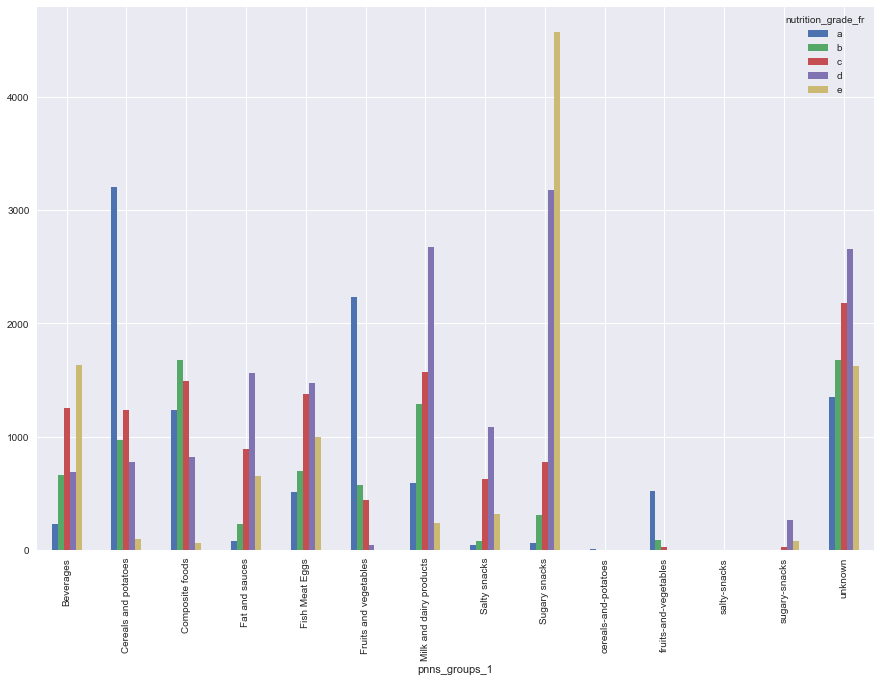

In [36]:
count_by_category.unstack().plot(kind='bar', figsize=(15,10))

On peut ainsi voir, que pour ce jeu de données, les catégories d'articles déclarées comme étant les plus saines (catégorie A) sont les "céréales et pommes de terre" puis les "fruits et légumes", et que la pire (caégorie E) est celle des snacks sucrés, suivie des boissons.

<h5>ACP avec la variable construite predict_score_sain</h5>

In [37]:
def grapheACP2Composantes2(_val_vect_propres, _df, _var_prediction, _num_comp_inf, _num_comp_sup):
    """Représentation graphique des deux composantes principales de l'ACP pour la variable à prédire sain (S) / pas sain (NS)
    Arguments:
    _val_vect_propres -- tuples des valeurs propres et des vecteurs propres de la matrice de corrélation
    _df -- dataframe des variables continues dont les valeurs manquantes ont été mises à 0
    _var_prediction -- variable à prédire
    _num_comp_inf -- numéro d'une des deux composantes principales à afficher
    _num_comp_inf -- numéro de l'autre des composantes principales à afficher
    """

    # tri des tuples (eigenvalue, eigenvector) par ordre décroissant
    _val_vect_propres.sort(key=lambda x: x[0], reverse=True)
    matrix_w = np.hstack((_val_vect_propres[_num_comp_inf][1].reshape(_df.shape[1],1), _val_vect_propres[_num_comp_sup][1].reshape(_df.shape[1],1)))

    Y = _df.dot(matrix_w)

    the_grid = GridSpec(2,2)
    plt.clf()
    plt.figure(figsize=(20,20))
    
    plt.subplot(the_grid[0,0], aspect=1)

    for lab, col, m in zip(('S', 'NS', 'NA'), ('lime', (1,0,0,0.3), 'blue'), ('o', '^', '+')):
        plt.scatter(Y[_var_prediction==lab, 0], Y[_var_prediction==lab, 1], label=lab, c=col, marker=m)
    plt.xlabel('Composante principale '+str(1+_num_comp_inf))
    plt.ylabel('Composante principale '+str(1+_num_comp_sup))
    plt.title(u"ACP, représentation des composantes principales "+str(1+_num_comp_inf)+" et "+str(1+_num_comp_sup)+u" avec la variable de saineté")
    plt.legend(loc='center')
    
    plt.subplot(the_grid[0,1], aspect=1)
    
    for lab, col, m in zip(('', 'NS'), ('lime', (1,0,0,0.3)), ('', '^')):
        plt.scatter(Y[_var_prediction==lab, 0], Y[_var_prediction==lab, 1], label=lab, c=col, marker=m)
    plt.xlabel('Composante principale '+str(1+_num_comp_inf))
    plt.ylabel('Composante principale '+str(1+_num_comp_sup))
    plt.title(u'Mise en valeur de la donnée non saine (NS)')
    plt.legend(loc='center')
    
    plt.subplot(the_grid[1,0], aspect=1)
    
    
    for lab, col, m in zip(('S', ''), ('lime', 'red'), ('o', '')):
        plt.scatter(Y[_var_prediction==lab, 0], Y[_var_prediction==lab, 1], label=lab, c=col, marker=m)
    plt.xlabel('Composante principale '+str(1+_num_comp_inf))
    plt.ylabel('Composante principale '+str(1+_num_comp_sup))
    plt.title(u'Mise en valeur de la donnée saine (S)')
    plt.legend(loc='center')
    
    plt.subplot(the_grid[1,1], aspect=1)
    
    for lab, col, m in zip(('', 'NA'), ('lime', 'blue'), ('', '+')):
        plt.scatter(Y[_var_prediction==lab, 0], Y[_var_prediction==lab, 1], label=lab, c=col, marker=m)
    plt.xlabel('Composante principale '+str(1+_num_comp_inf))
    plt.ylabel('Composante principale '+str(1+_num_comp_sup))
    plt.title(u'Mise en valeur de la donnée non renseignée (NA)')
    plt.legend(loc='center') 
    
    plt.show()
    

<h5>Comparaison des composantes 1 et 2 de l'ACP vis-à-vis du critère de sanité</h5>
- L'axe 1 représente les acides gras (acides arachidique, béhénique, gamme-linolénique etc.)
- L'axe 2 représente les scores et certaines variables à haut potentiel "énergétique" (energy, fat, saturated-fat, sugars) 

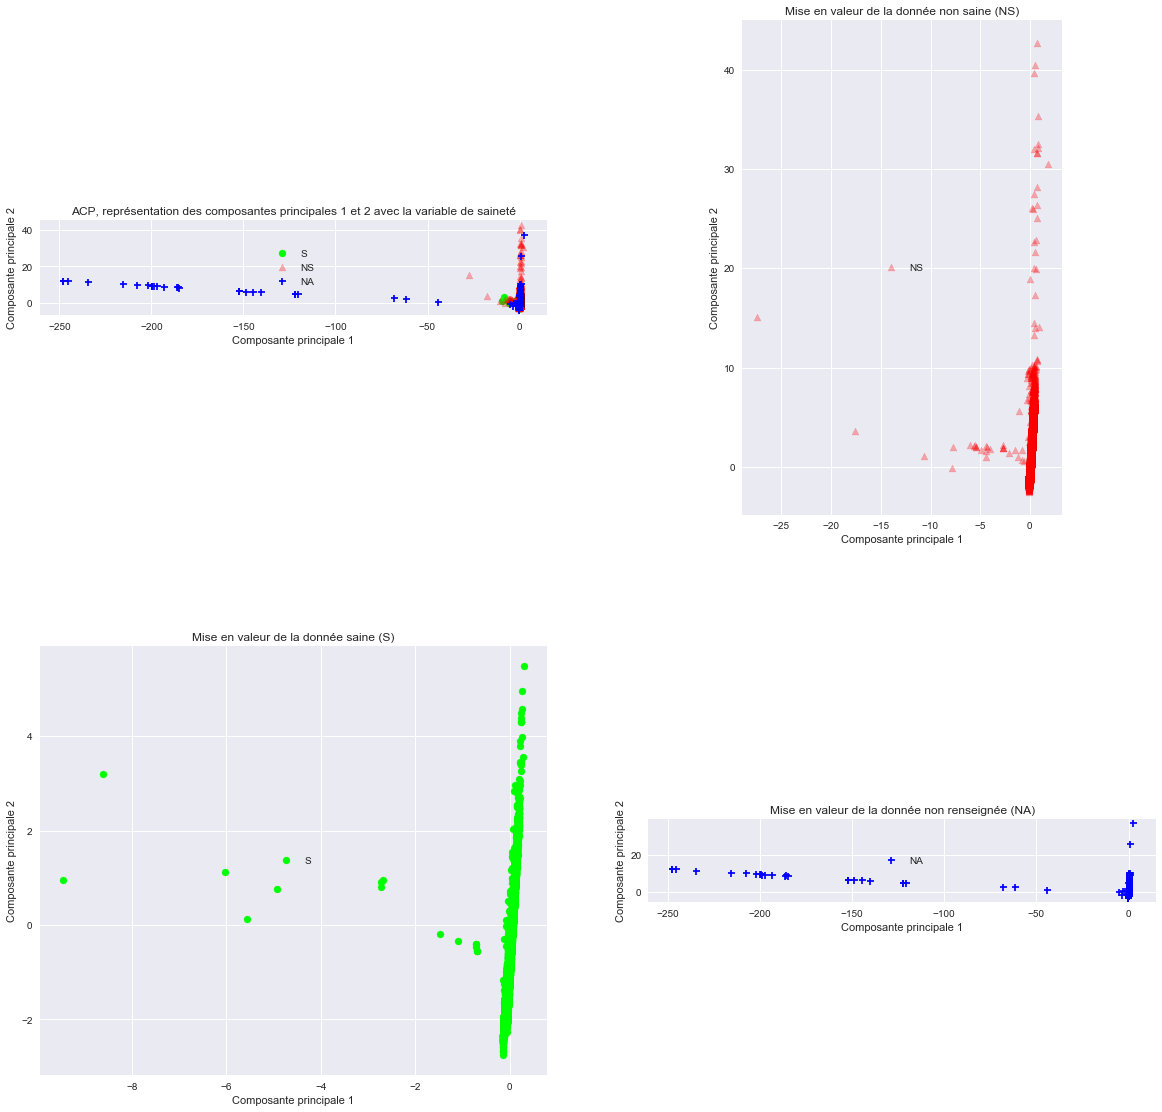

In [38]:
dfContinuesSkewedSansNaNNormalise = prep.StandardScaler().fit_transform(dfContinuesSkewedSansNaN)
eig_pairsSain = getPropre(dfContinuesSkewedSansNaNNormalise, False)
grapheACP2Composantes2(eig_pairsSain, dfContinuesSkewedSansNaNNormalise, predict_score_sain, 0, 1)

<u>Commentaires</u> :<br>
- L'axe 1 représente les acides gras (acides arachidique, béhénique, gamme-linolénique etc.)
- L'axe 2 représente les scores et certaines variables à haut potentiel "énergétique" (energy, fat, saturated-fat, sugars) 
- On observe dans ces graphiques que les articles situés sur la première composante sont des articles pour lesquels il n'y a pas de score nutritionnel. 
- Les articles non sains se retrouvent sur les deux composantes, mais principalement sur la composante 2, ce qui semble logique puisque la composante 2 est composée de variables dont les fortes valeurs influent très négativement sur le score nutritionnel.
- Les articles sains se retrouvent un peu sur la composante 1, mais surtout sur la composante 2 pour de faibles valeurs. 
- La présence d'acides gras ne semble pas être déterminante pour dire si un article est sain ou non, cela dépend de la spécificité de chaque acide, et des conditions ("posologie"). 
- La composante contenant les scores, c'est donc elle qui permet de mieux discriminer des articles sains ou non. 
- Toutefois, il s'agit d'observations sur la "sanité" des articles et non sur celle d'éventuelles recettes dont le score spécifique est à établir.

<h5>Comparaison des composantes 1 et 3 de l'ACP vis-à-vis du critère de sanité</h5>
- L'axe 1 représente les acides gras (acides arachidique, béhénique, gamme-linolénique etc.)
- L'axe 3 représente certains oligo-éléments (molybdène, chrome, bêta-carotène, cuivre etc.) 

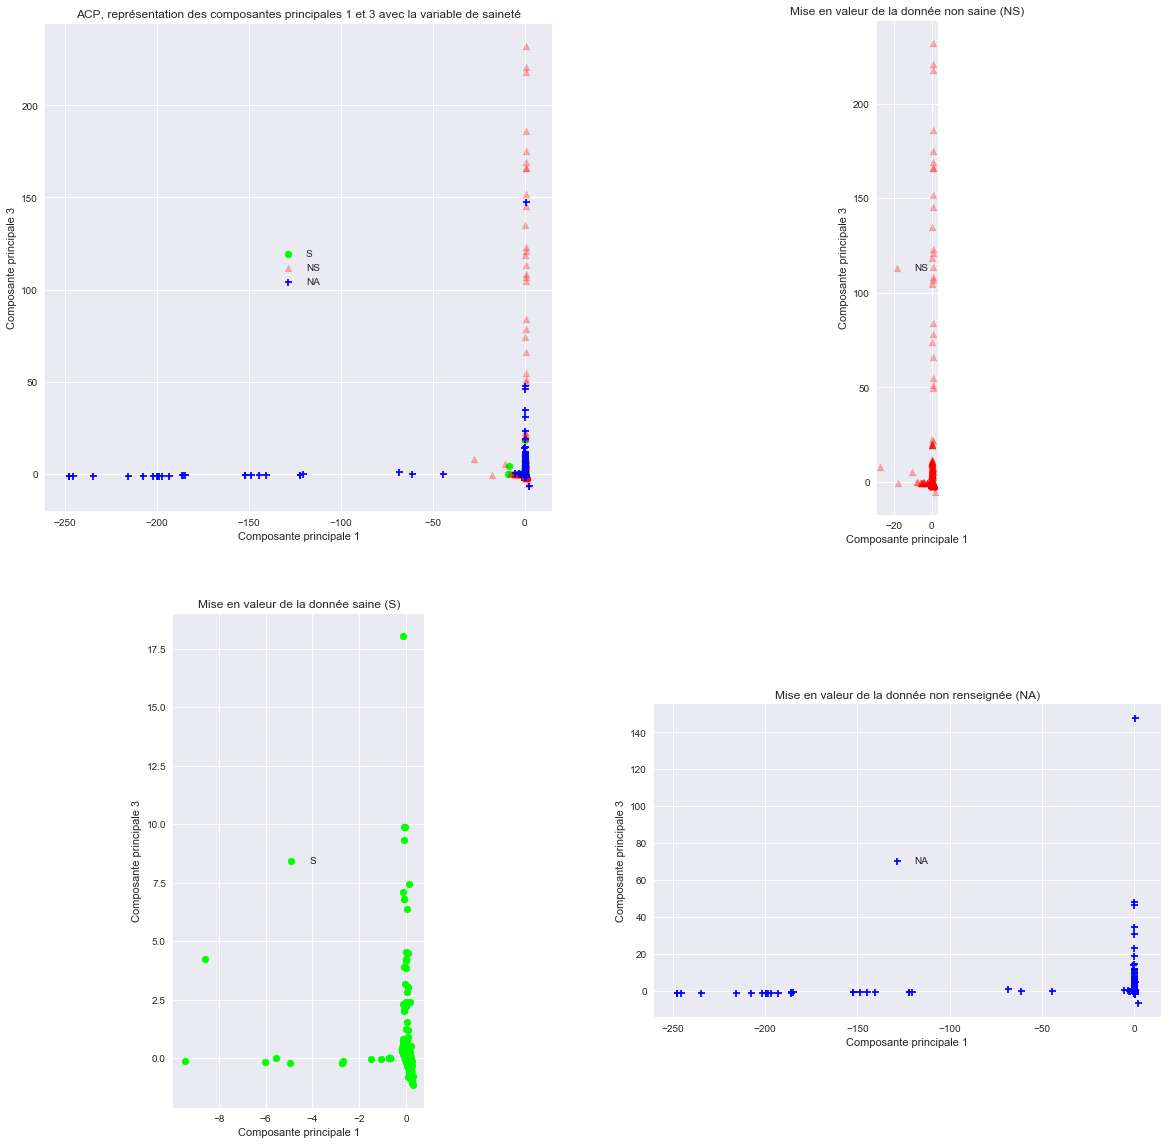

In [39]:
grapheACP2Composantes2(eig_pairsSain, dfContinuesSkewedSansNaNNormalise, predict_score_sain, 0, 2)

<u>Commentaires</u> :<br>
- L'axe 1 représente les acides gras (acides arachidique, béhénique, gamme-linolénique etc.)
- L'axe 3 représente certains oligo-éléments (molybdène, chrome, bêta-carotène, cuivre etc.) 
- De la même façon que pour les deux premières composantes principales, les articles sains se trouvent sur des valeurs peu élevées des composantes 1 et 3, les articles non sains possèdent des valeurs élevées sur la composante 3 de ces oligo-éléments.

On retrouve globalement la même analyse pour les autres composantes principales.
- Les articles possédant des valeurs élevées des différents composants ne sont pas sains.
- Pour les valeurs moins élevées, certains articles sont sains, d'autres non. 

<h5>Calcul déterministe d'un score de recette basé sur le modèle du score d'un article</h5>

Un article est l'agrégat de ses constituants (ou ingrédients). 
Si on suppose qu'une recette est l'agrégat d'articles (le cahier des charges du projet ne précise pas ce qu'est une recette), alors moyennant certaines hypothèses, on peut construire le score d'une recette en ce basant sur le score des articles. 
Puisque le score d'un article est construit en fonction des valeurs de sept variables le décrivant, que ces variables sont quantitatives et correspondent à des cumuls ramenés à une masse de référence (100g de produit de l'article), on peut faire exactement de même en additionnant les valeurs des différents articles de la recette, pour ces sept variables, que l'ont ramène à des valeurs références pour 100g de recette. On peut alors de la même façon que pour un article, calculer le score pour une recette. <br>
Il faut toutefois remarquer que le calcul des scores étant différents pour les articles solides et les articles liquides, une recette mélangeant articles solides et liquides, on doit séparer les articles de la recette en deux catégories, et donc établir deux scores, un score solide et un score liquide pour la recette. 


In [40]:
# fonctions du calcul des points A et C : 
# elles sont basées sur les données du site https://fr.openfoodfacts.org/score-nutritionnel-experimental-france
def getAenergyPoints(val):
    if val <= 335:    return 0
    elif val <= 670:  return 1
    elif val <= 1005: return 2
    elif val <= 1340: return 3
    elif val <= 1675: return 4
    elif val <= 2010: return 5
    elif val <= 2345: return 6
    elif val <= 2680: return 7
    elif val <= 3015: return 8
    elif val <= 3350: return 9
    else:             return 10
def getAsaturatedfatPoints(val):
    if val <= 1:   return 0
    elif val <= 2: return 1
    elif val <= 3: return 2
    elif val <= 4: return 3
    elif val <= 5: return 4
    elif val <= 6: return 5
    elif val <= 7: return 6
    elif val <= 8: return 7
    elif val <= 9: return 8
    elif val <= 9: return 9
    else:          return 10   
def getAsugarsPoints(val):
    if val <= 4.5:    return 0
    elif val <= 9:    return 1
    elif val <= 13.5: return 2
    elif val <= 18:   return 3
    elif val <= 22.5: return 4
    elif val <= 27:   return 5
    elif val <= 31:   return 6
    elif val <= 36:   return 7
    elif val <= 40:   return 8
    elif val <= 45:   return 9
    else:             return 10
def getAsodiumPoints(val):
    if   val <= 0.090:  return 0
    elif val <= 0.180:  return 1
    elif val <= 0.270:  return 2
    elif val <= 0.360:  return 3
    elif val <= 0.450:  return 4
    elif val <= 0.540:  return 5
    elif val <= 0.630:  return 6
    elif val <= 0.720:  return 7
    elif val <= 0.810:  return 8
    elif val <= 0.900:  return 9
    else:               return 10   
def getCfruitsPoints(val):
    if   val <= 40: return 0
    elif val <= 60: return 1
    elif val <= 80: return 2
    else:           return 5  
def getCfibresPoints(val):
    if   val <= 0.7: return 0
    elif val <= 1.4: return 1
    elif val <= 2.1: return 2
    elif val <= 2.8: return 3
    elif val <= 3.5: return 4
    else:            return 5  
def getCproteinsPoints(val):
    if   val <= 1.6: return 0
    elif val <= 3.2: return 1
    elif val <= 4.8: return 2
    elif val <= 6.4: return 3
    elif val <= 8:   return 4
    else:            return 5  

def getScoreRecette(_df, _csvReader):
    """
    Méthode qui calcule le score d'une recette
    Arguments:
    _df -- le dataframe contenant les valeurs
    _csvReader -- le reader de csv permettant de lire les proportions des articles de la recette
    Retour: les deux scores de la recette, solide et liquide
    """    
    print(_df.shape)
    # on supprime tous les articles qui n'ont pas de score
    dfOriginelScore = _df[np.isnan(_df['nutrition-score-uk_100g']) == False]
    print(dfOriginelScore.shape)
    # on ne garde que les 7 variables utiles + code + quantity + score
    dfVarScore = dfOriginelScore[['code', 'energy_100g', 'saturated-fat_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g', 'proteins_100g', 'fruits-vegetables-nuts_100g', 'quantity', 'nutrition-score-uk_100g']]
    # on détermine si l'article est solide ou liquide (ou aucun des deux)
    solide = np.where(dfOriginelScore["quantity"].str.contains("l|L")==False, 1, 0)
    liquide = np.where(dfOriginelScore["quantity"].str.contains("l|L")==True, 1, 0)
    dsl = {'solide' : solide, 'liquide' : liquide}
    dfsl = pd.DataFrame(dsl)
    dfVarScoreQuality = pd.concat([dfVarScore, dfsl], axis = 1)
    # on passe code en index afin d'utiliser les codes
    dfVarScoreQuality = dfVarScoreQuality.set_index('code', drop=False)

    # Le fichier recette.csv est fourni avec les livrables, mais on peut choisir ce qu'on veut du moment que les articles choisis 
    # possèdent toutes les valeurs nécessaires (en premier lieu le score, normalement si le score est présent alors toutes les autres variables sont également présentes) 
    # Contenu du fichier fourni : 
    # 3560070464791\t100\n3329770044654\t100\n4008471483083\t200\n3451790397509\t50\n3173610005028\t100\n3300060420105\t50
    # une colonne avec les 5 codes d'article, l'autre colonne avec les 5 portions de ces articles (en grammes)

    listeCodes = []
    listeQuantities = []
    for row in _csvReader:
        listeCodes.append(int((row[0].split('\t'))[0]))
        listeQuantities.append(int((row[0].split('\t'))[1]))
    print("liste des codes", listeCodes)
    print("liste des portions", listeQuantities)

    # calcul des moyennes des variables utilisées dans le score britannique pour 100g de recette
    moyennes_solide = dict()
    moyennes_liquide = dict()

    for varName in ['fruits-vegetables-nuts_100g', 'energy_100g', 'saturated-fat_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g', 'proteins_100g']:
        cumul_solide = cumul_liquide = 0
        nb_solide = nb_liquide = 0
        moy_solide = moy_liquide = 0
        cumul_portion_solide = cumul_portion_liquide = 0
        for code, portion in zip(listeCodes, listeQuantities):
            if not re.search("L|l", dfVarScoreQuality.ix[code,'quantity']):
                nb_solide = nb_solide + 1
                cumul_portion_solide = cumul_portion_solide + portion
                if varName == 'fruits-vegetables-nuts_100g':
                    cumul_solide = cumul_solide + dfVarScoreQuality.ix[code,varName] * portion
                else:
                    cumul_solide = cumul_solide + dfVarScoreQuality.ix[code,varName] * portion / 100.0
            elif re.search("L|l", dfVarScoreQuality.ix[code,'quantity']):
                nb_liquide = nb_liquide + 1
                cumul_portion_liquide = cumul_portion_liquide + portion
                if varName == 'fruits-vegetables-nuts_100g':
                    cumul_liquide = cumul_liquide + dfVarScoreQuality.ix[code,varName] * portion
                else:
                    cumul_liquide = cumul_liquide + dfVarScoreQuality.ix[code,varName] * portion / 100.0

        if nb_solide > 0:
            if varName == 'fruits-vegetables-nuts_100g':
                moy_solide = cumul_solide / cumul_portion_solide
            else:
                moy_solide = cumul_solide * 100.0 / cumul_portion_solide
        if nb_liquide > 0:
            if varName == 'fruits-vegetables-nuts_100g':
                moy_liquide = cumul_liquide / cumul_portion_liquide
            else:
                moy_liquide = cumul_liquide * 100.0 / cumul_portion_liquide

        moyennes_solide[varName]= moy_solide
        moyennes_liquide[varName] = moy_liquide

    # SOLIDE
    scoreSolideA = getAenergyPoints(moyennes_solide["energy_100g"]) + getAsaturatedfatPoints(moyennes_solide["saturated-fat_100g"]) + getAsugarsPoints(moyennes_solide["sugars_100g"]) + getAsodiumPoints(moyennes_solide["sodium_100g"])
    scoreSolideC = getCfruitsPoints(moyennes_solide["fruits-vegetables-nuts_100g"]) + getCfibresPoints(moyennes_solide["fiber_100g"]) + getCproteinsPoints(moyennes_solide["proteins_100g"])

    scoreSolide = 0
    if scoreSolideA < 11:
        scoreSolide = scoreSolideA - scoreSolideC
    else:
        if getCfruitsPoints(moyennes_solide["fruits-vegetables-nuts_100g"]) == 5:
            scoreSolide = scoreSolideA - scoreSolideC
        else:
            scoreSolide = scoreSolideA - (moyennes_solide["fruits-vegetables-nuts_100g"]+moyennes_solide["fiber_100g"])

    # LIQUIDE
    scoreLiquideA = getAenergyPoints(moyennes_liquide["energy_100g"]) + getAsaturatedfatPoints(moyennes_liquide["saturated-fat_100g"]) + getAsugarsPoints(moyennes_liquide["sugars_100g"]) + getAsodiumPoints(moyennes_liquide["sodium_100g"])
    scoreLiquideC = getCfruitsPoints(moyennes_liquide["fruits-vegetables-nuts_100g"]) + getCfibresPoints(moyennes_liquide["fiber_100g"]) + getCproteinsPoints(moyennes_liquide["proteins_100g"])

    scoreLiquide = 0
    if scoreLiquideA < 11:
        scoreLiquide = scoreLiquideA - scoreLiquideC
    else:
        if getCfruitsPoints(moyennes_liquide["fruits-vegetables-nuts_100g"]) == 5:
            scoreLiquide = scoreLiquideA - scoreLiquideC
        else:
            scoreLiquide = scoreLiquideA - (moyennes_liquide["fruits-vegetables-nuts_100g"]+moyennes_liquide["fiber_100g"])

    return scoreSolide, scoreLiquide


scoreSolide, scoreLiquide = getScoreRecette(dfOriginel, csvReader)
print("Score de la recette Solide", scoreSolide)
print("Score de la recette Liquide", scoreLiquide)

(139578, 160)
(72599, 160)
('liste des codes', [3499603010436L, 5410188030266L, 3597620005722L, 3245414091221L, 3299511291268L])
('liste des portions', [50, 200, 100, 100, 50])
('Score de la recette Solide', 0)
('Score de la recette Liquide', -4)


C'est une recette factice qui contient : 
- un liquide (3499603010436), avec 50cl de jus d'orange de score -3
- un liquide (5410188030266), avec 200cl de soupe de score -4
- un solide (3597620005722), avec 100g de cruesli 4 noix de score 7
- un solide (3245414091221), avec 100g de colin de score 1
- un solide (3299511291268), avec 50g de lasagnes de score 3

On obtient ainsi une recette donc le score liquide est de -4 et le score solide est de 0. <br>
Que ce soit pour sa composition liquide ou solide, cette recette peut être consédérée (dans l'hypothèse que les consitions initiales sont réalistes et ont un sens) comme saine. 

<h5>Essai de modèle pour prédire le score d'article</h5>

Puisqu'un article comprend des ingrédients (variable ingredients_text), l'idée est de voir si on peut relier ces ingrédients au score nutritionnel en fonction de leur présence ou non dans les articles. <br>
- La première étape consiste donc à faire une liste de tous les ingrédients existant dans le jeu de données.
- La deuxième crée les variables indiquant si un ingrédient est présent ou non dans les articles
- La troisième consiste à tester deux modèles possibles et voir si cela donne des résultats  

1- Liste des ingrédients :

In [41]:
dfOriginel = dfOriginel.iloc[dfOriginel['nutrition-score-uk_100g'].dropna().index.values]
ingedients = dfOriginel.select_dtypes(include=['object'])['ingredients_text']
ingedients = pd.DataFrame(ingedients.dropna()).reset_index(drop=True)
print(ingedients.head())

stemmer =  LancasterStemmer()
lemmer = WordNetLemmatizer()
stop = stopwords.words('english')
alpha_tokenizer = RegexpTokenizer('[A-Za-z]\w+')

                                    ingredients_text
0  INGREDIENTS : LAITUE. VINAIGRETTE (HUILE DE CA...
1  Ingrédients : Pâte (farine, margarines d'huile...
2  Ingrédients : Farine, eau, sel, levure, orge m...
3  Demerara Sugar, Sultanas (14%), Raisins (9.4%)...
4  Demerara Sugar, Sultanas (14%), Raisins (9.4%)...


In [42]:
def text_to_wordlist(text, remove_stop_words=False, stem_words=False):
    # Clean the text, with the option to remove stop_words and to stem words.

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

def process_sent(words, lemmatize=True):
    words = words.lower()
    words = text_to_wordlist(words)
    tokens = alpha_tokenizer.tokenize(words)
    for index, word in enumerate(tokens):
        if lemmatize:
            tokens[index] = lemmer.lemmatize(word)
        else:
            tokens[index] = stemmer.stem(word)
    return tokens

texts = np.concatenate([ingedients.ingredients_text.values])
corpus = [process_sent(sent) for sent in texts]

VECTOR_SIZE = 100
min_count = 5
size = VECTOR_SIZE
window = 100

model_lemmatized = models.Word2Vec(corpus, min_count=min_count, size=size, window=window)

print(len(model_lemmatized.wv.vocab))

6105


Le jeu de données contient 6105 termes d'ingrédients. <br>
Si on prend par exemple l'ingrédient "onion", on peut obtenir les ingrédients qui lui sont le plus souvent associés :

In [43]:
model_lemmatized.most_similar('onion')

[('pepper', 0.9661810994148254),
 ('garlic', 0.9577480554580688),
 ('celery', 0.8952416181564331),
 ('parsley', 0.8922790288925171),
 ('mushroom', 0.8832991123199463),
 ('black', 0.87026047706604),
 (u'chilli', 0.8627510070800781),
 ('red', 0.8585730791091919),
 ('spice', 0.8538507223129272),
 (u'potato', 0.8521978259086609)]

2- Création des variables indiquant si chaque ingrédient est présent :

In [44]:
clefs = list(model_lemmatized.wv.vocab.keys())
list_var = []
for i in range(len(clefs)):
    dfOriginel["pr_"+str(clefs[i])] = np.where(dfOriginel["ingredients_text"].str.contains(clefs[i])==True, 1, 0)
    list_var.append("pr_"+str(clefs[i])) 

3- Modèles

In [45]:
data_input = dfOriginel[list_var]

# Entraînement avec tous les enregistrements sauf les 1000 derniers
X_train = data_input[:-1000]
Y_train = dfOriginel['nutrition-score-uk_100g'][:-1000]
# Test des 1000 derniers enregistrements
X_test = data_input[-1000:]
Y_test = dfOriginel['nutrition-score-uk_100g'][-1000:]

# Modèle de l'algorithm Random Forest
mod = RandomForestRegressor(n_estimators = 10, n_jobs = -1, min_samples_split=3)
mod.fit(X_train, Y_train)
Y_pred = mod.predict(X_test)
print("RandomForest r2_score : {0}".format(r2_score(Y_pred, Y_test)))
print("RandomForest mean_squared_error : {0}".format(mean_squared_error(Y_pred, Y_test)))

# Modèle de régression linéaire
lr = linear_model.LinearRegression()
lr.fit(X_train, Y_train)
print("Régression linéaire r2_score : {0}".format(r2_score(lr.predict(X_test), Y_test)))

print(Y_test[:5])
print(Y_pred[:5])

RandomForest r2_score : -1.2264509019
RandomForest mean_squared_error : 61.6098303687
Régression linéaire r2_score : -0.000646048581523
135795    17.0
135796    15.0
135797    15.0
135798    15.0
135803     9.0
Name: nutrition-score-uk_100g, dtype: float64
[  9.04588359   9.04588359   9.04588359  12.84         9.04588359]


Les scores r2 pour les deux modèles ne sont pas bons. <br>
On le voit clairement dans la différence entre les scores nutritionnels réels et les scores nutritionnels prédits. 

Pouvoir prédire les scores des articles nécessite donc de plus amples recherches. 